In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

In [3]:
tag_df = pd.read_csv("ml-20m/ml-20m/tags.csv")
tag_df.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [4]:
tag_df.shape

(465564, 4)

In [5]:
tag_df.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [6]:


tag_df.rename(columns={'tag':'user_tag'}, inplace=True)


tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])
tag_df['year'] = tag_df['timestamp'].dt.year
tag_df['month'] = tag_df['timestamp'].dt.month



tag_df['user_tag'] = tag_df['user_tag'].str.lower()

In [7]:
print(tag_df.head())
tag_df.shape

   userId  movieId       user_tag                     timestamp  year  month
0      18     4141    mark waters 1970-01-01 00:00:01.240597180  1970      1
1      65      208      dark hero 1970-01-01 00:00:01.368150078  1970      1
2      65      353      dark hero 1970-01-01 00:00:01.368150079  1970      1
3      65      521  noir thriller 1970-01-01 00:00:01.368149983  1970      1
4      65      592      dark hero 1970-01-01 00:00:01.368150078  1970      1


(465564, 6)

In [8]:
tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     465564 non-null  int64         
 1   movieId    465564 non-null  int64         
 2   user_tag   465548 non-null  object        
 3   timestamp  465564 non-null  datetime64[ns]
 4   year       465564 non-null  int32         
 5   month      465564 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(2), object(1)
memory usage: 17.8+ MB


In [9]:
tag_df.user_tag.value_counts()

user_tag
sci-fi                      3576
based on a book             3307
atmospheric                 3169
comedy                      3078
action                      3068
                            ... 
touchstone                     1
pg:some brief language         1
playwright:aaron sorkin        1
screenwriter:neil labute       1
topless scene                  1
Name: count, Length: 35172, dtype: int64

In [10]:

tag_df.user_tag.value_counts().head(10)


user_tag
sci-fi              3576
based on a book     3307
atmospheric         3169
comedy              3078
action              3068
nudity (topless)    2646
surreal             2528
twist ending        2367
bd-r                2334
funny               2253
Name: count, dtype: int64

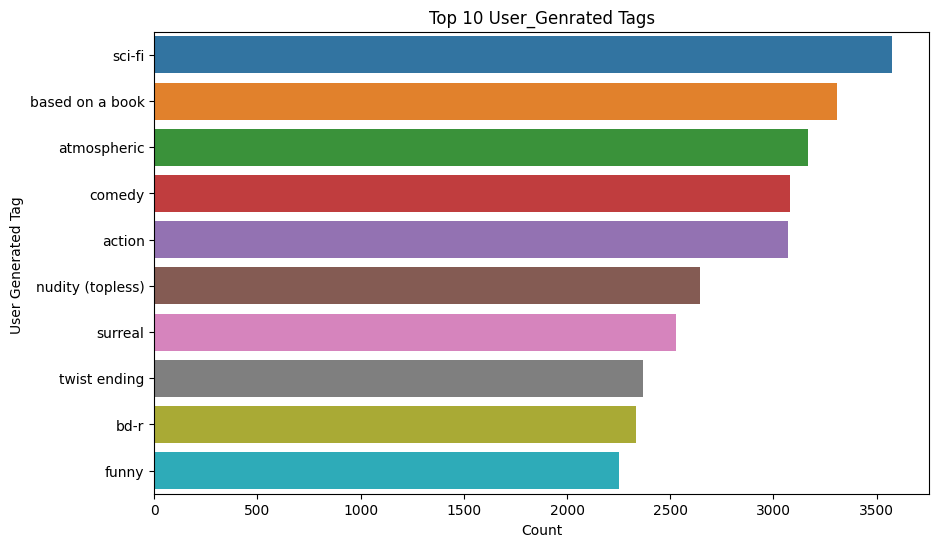

In [11]:

common_tags = tag_df['user_tag'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=common_tags.values,y=common_tags.index, orient='h')
plt.title('Top 10 User_Genrated Tags')
plt.xlabel("Count")
plt.ylabel("User Generated Tag ")
plt.show()

In [12]:
rating_df = pd.read_csv("ml-20m/ml-20m/ratings.csv")
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [13]:
rating_df.shape

(20000263, 4)

In [14]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [15]:

rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])
rating_df['year'] = rating_df['timestamp'].dt.year
rating_df['month'] = rating_df['timestamp'].dt.month


In [16]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
 4   year       int32         
 5   month      int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 762.9 MB


In [17]:
print(rating_df.head())
rating_df.shape

   userId  movieId  rating                     timestamp  year  month
0       1        2     3.5 1970-01-01 00:00:01.112486027  1970      1
1       1       29     3.5 1970-01-01 00:00:01.112484676  1970      1
2       1       32     3.5 1970-01-01 00:00:01.112484819  1970      1
3       1       47     3.5 1970-01-01 00:00:01.112484727  1970      1
4       1       50     3.5 1970-01-01 00:00:01.112484580  1970      1


(20000263, 6)

In [18]:
rating_df.rating.value_counts()

rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64

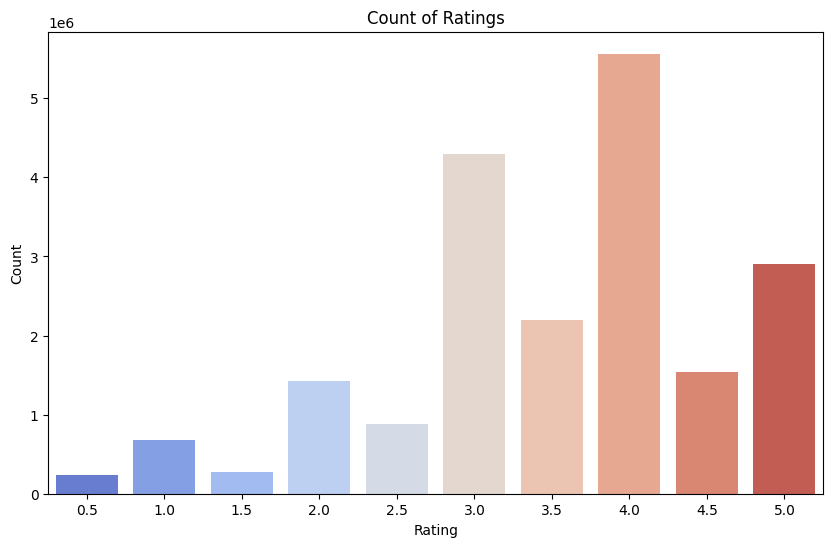

In [19]:


plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=rating_df, palette='coolwarm')
plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


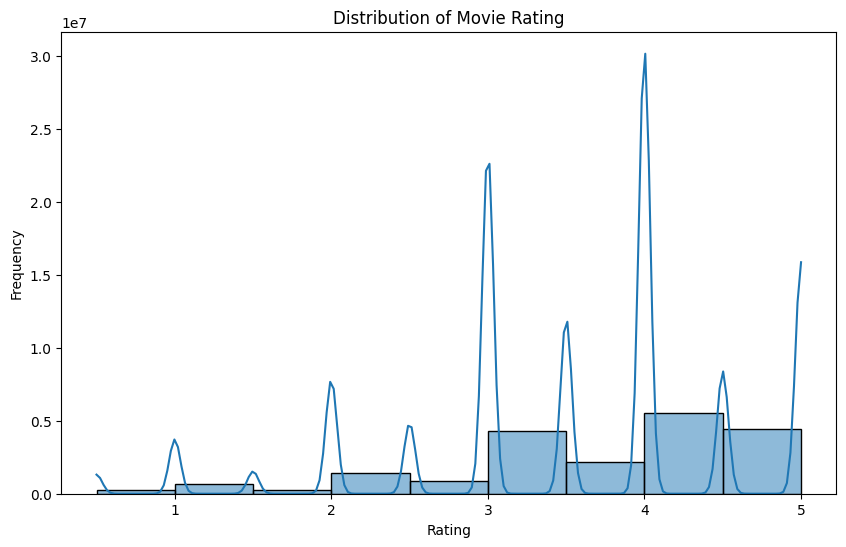

In [20]:

plt.figure(figsize=(10, 6))
sns.histplot(rating_df['rating'], bins=9, kde=True)
plt.title('Distribution of Movie Rating')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


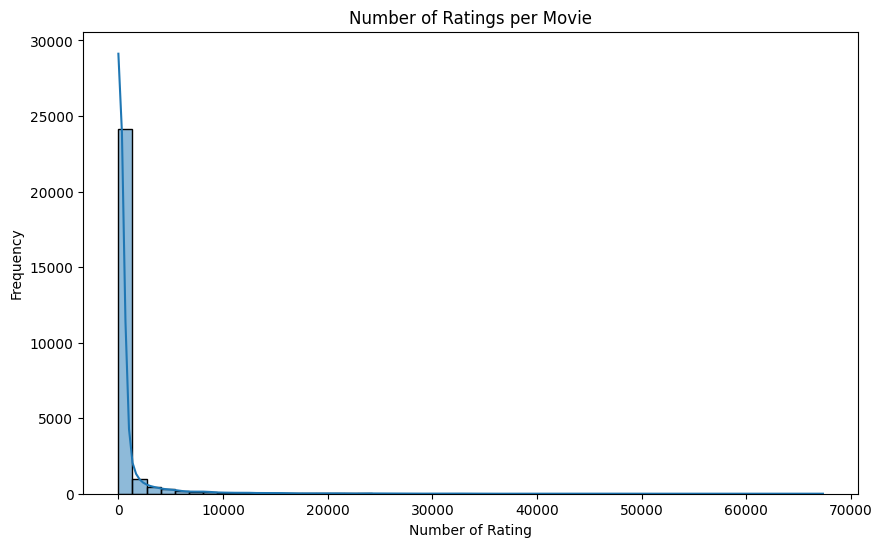

In [21]:
ratings_per_movie = rating_df.groupby('movieId')['rating'].count()
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel("Number of Rating")
plt.ylabel("Frequency")
plt.show()

In [22]:
movie_df = pd.read_csv("ml-20m/ml-20m/movies.csv")

In [23]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
movie_df.shape

(27278, 3)

In [25]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [26]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [27]:

movie_df['genres'] = movie_df['genres'].str.split('|')
movie_df

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),[Comedy]
27274,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy]
27275,131258,The Pirates (2014),[Adventure]
27276,131260,Rentun Ruusu (2001),[(no genres listed)]


In [28]:

movie_df_new = movie_df.copy()


movie_df_new['release_year'] = movie_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movie_df_new['movie_title'] = movie_df['title'].str.replace(r'\(\d{4}\)', '').str.strip()


movie_df_new['genres'] = movie_df_new['genres'].str.split('|')

movie_df_new = movie_df_new.drop('title', axis=1)
movie_df_new = movie_df_new[['movieId', 'movie_title', 'release_year', 'genres']]

movie_df_new.head(10)


,movieId,movie_title,release_year,genres
0,1,Toy Story (1995),1995,NaN
1,2,Jumanji (1995),1995,NaN
2,3,Grumpier Old Men (1995),1995,NaN
3,4,Waiting to Exhale (1995),1995,NaN
4,5,Father of the Bride Part II (1995),1995,NaN
5,6,Heat (1995),1995,NaN
6,7,Sabrina (1995),1995,NaN
7,8,Tom and Huck (1995),1995,NaN
8,9,Sudden Death (1995),1995,NaN
9,10,GoldenEye (1995),1995,NaN


In [29]:
print(movie_df_new.head())
movie_df_new.shape

   movieId                         movie_title release_year  genres
0        1                    Toy Story (1995)         1995     NaN
1        2                      Jumanji (1995)         1995     NaN
2        3             Grumpier Old Men (1995)         1995     NaN
3        4            Waiting to Exhale (1995)         1995     NaN
4        5  Father of the Bride Part II (1995)         1995     NaN


(27278, 4)

In [30]:
movie_df_new.release_year.value_counts()

release_year
2009    1113
2012    1022
2011    1016
2013    1011
2008     979
        ... 
1893       1
1901       1
1903       1
1902       1
1891       1
Name: count, Length: 118, dtype: int64

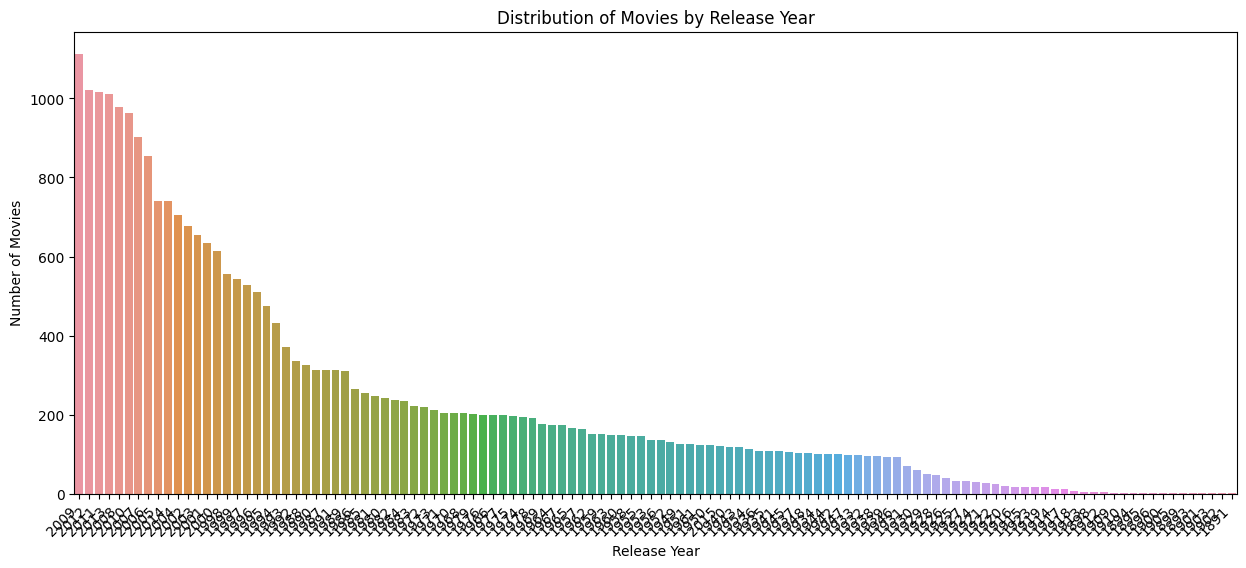

In [31]:

plt.figure(figsize=(15, 6))
sns.countplot(x='release_year', data=movie_df_new, order=movie_df_new['release_year'].value_counts().index)
plt.title('Distribution of Movies by Release Year')
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [32]:
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       27278 non-null  int64  
 1   movie_title   27278 non-null  object 
 2   release_year  27256 non-null  object 
 3   genres        0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 852.6+ KB


In [33]:

movie_df_new['release_year'] = pd.to_datetime(movie_df_new['release_year'], errors='coerce')


In [34]:
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   movieId       27278 non-null  int64         
 1   movie_title   27278 non-null  object        
 2   release_year  27256 non-null  datetime64[ns]
 3   genres        0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 852.6+ KB


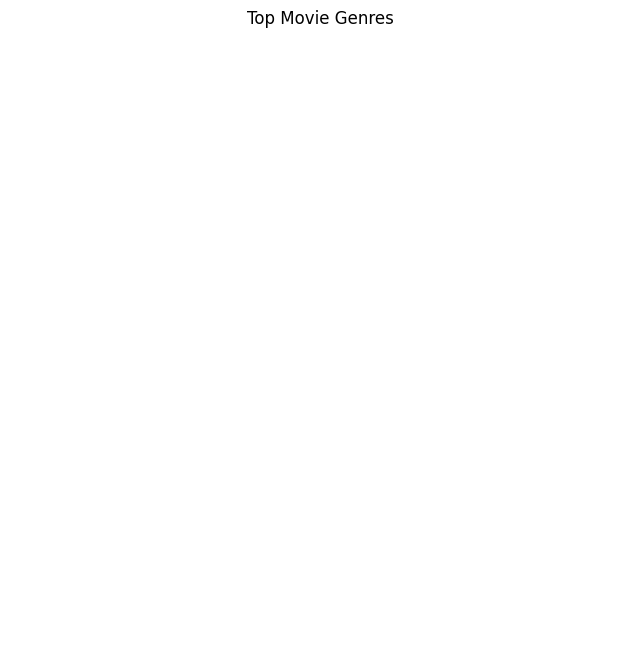

In [35]:


a = plt.cm.cool

top_genres = movie_df_new['genres'].explode().value_counts().head(10)
colors = [a(0.1), a(0.2), a(0.3), a(0.4), a(0.5), a(0.6), a(0.7), a(0.8), a(0.9), a(0.99)]


plt.figure(figsize=(8, 8))
plt.pie(top_genres.values, labels=top_genres.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top Movie Genres')
plt.axis('equal')

plt.show()


In [36]:
link_df = pd.read_csv("ml-20m/ml-20m/links.csv")
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [37]:
link_df.shape

(27278, 3)

In [38]:
link_df.isnull().sum()

movieId      0
imdbId       0
tmdbId     252
dtype: int64

In [39]:
link_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


In [40]:
link_df.describe()

,movieId,imdbId,tmdbId
count,27278.000000,2.727800e+04,27026.000000
mean,59855.480570,5.781860e+05,63846.683083
std,44429.314697,7.804707e+05,69862.134497
min,1.000000,5.000000e+00,2.000000
25%,6931.250000,7.741725e+04,15936.500000
50%,68068.000000,1.524350e+05,39468.500000
75%,100293.250000,9.062715e+05,82504.000000
max,131262.000000,4.530184e+06,421510.000000


In [41]:
genome_scores_df = pd.read_csv("ml-20m/ml-20m/genome-scores.csv")
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [42]:
genome_scores_df.shape

(11709768, 3)

In [43]:
genome_scores_df.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [44]:
genome_scores_df.rename(columns={'tagId':'genome_tag_Id'}, inplace=True)

In [45]:
genome_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   movieId        int64  
 1   genome_tag_Id  int64  
 2   relevance      float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


In [46]:
genome_scores_df.describe().round(2)

,movieId,genome_tag_Id,relevance
count,11709768.00,11709768.00,11709768.00
mean,25842.97,564.50,0.12
std,34676.15,325.63,0.15
min,1.00,1.00,0.00
25%,2926.00,282.75,0.02
50%,6017.00,564.50,0.06
75%,46062.00,846.25,0.14
max,131170.00,1128.00,1.00


In [47]:
genome_tags_df = pd.read_csv("ml-20m/ml-20m/genome-tags.csv")
genome_tags_df

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [48]:
genome_tags_df.shape

(1128, 2)

In [49]:
genome_tags_df.rename(columns={'tag':'genome_tag'}, inplace=True)

genome_tags_df.rename(columns={'tagId':'genome_tag_Id'}, inplace=True)

In [50]:
genome_tags_df.isnull().sum()

genome_tag_Id    0
genome_tag       0
dtype: int64

In [51]:
genome_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genome_tag_Id  1128 non-null   int64 
 1   genome_tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [52]:
print(tag_df.head())
print(rating_df.head())
print(movie_df.head())
print(link_df.head())
print(genome_scores_df.head())
print(genome_tags_df.head())

   userId  movieId       user_tag                     timestamp  year  month
0      18     4141    mark waters 1970-01-01 00:00:01.240597180  1970      1
1      65      208      dark hero 1970-01-01 00:00:01.368150078  1970      1
2      65      353      dark hero 1970-01-01 00:00:01.368150079  1970      1
3      65      521  noir thriller 1970-01-01 00:00:01.368149983  1970      1
4      65      592      dark hero 1970-01-01 00:00:01.368150078  1970      1
   userId  movieId  rating                     timestamp  year  month
0       1        2     3.5 1970-01-01 00:00:01.112486027  1970      1
1       1       29     3.5 1970-01-01 00:00:01.112484676  1970      1
2       1       32     3.5 1970-01-01 00:00:01.112484819  1970      1
3       1       47     3.5 1970-01-01 00:00:01.112484727  1970      1
4       1       50     3.5 1970-01-01 00:00:01.112484580  1970      1
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2        

In [53]:

data = pd.merge(movie_df,rating_df, how='inner', on="movieId")

In [54]:
data

,movieId,title,genres,userId,rating,timestamp,year,month
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3,4.0,1970-01-01 00:00:00.944919407,1970,1
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",6,5.0,1970-01-01 00:00:00.858275452,1970,1
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",8,4.0,1970-01-01 00:00:00.833981871,1970,1
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",10,4.0,1970-01-01 00:00:00.943497887,1970,1
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",11,4.5,1970-01-01 00:00:01.230858821,1970,1
...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),[Comedy],79570,4.0,1970-01-01 00:00:01.427743979,1970,1
20000259,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy],79570,4.0,1970-01-01 00:00:01.427744888,1970,1
20000260,131258,The Pirates (2014),[Adventure],28906,2.5,1970-01-01 00:00:01.427745392,1970,1
20000261,131260,Rentun Ruusu (2001),[(no genres listed)],65409,3.0,1970-01-01 00:00:01.427745466,1970,1


In [55]:

def missing_values_analysis(data):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(data, row_num=5, col_num=10):
    print("*************** Dataset Shape ***************")
    print("No. of Rows:", data.shape[0], "\nNo. of Columns:", data.shape[1])
    print("*************** Dataset Information ***************")
    print(data.info())
    print("*************** Types of Columns ***************")
    print(data.dtypes)
    print(f"*************** First {row_num} Rows ***************")
    print(data.iloc[:row_num,:col_num])
    print(f"*************** Last {row_num} Rows ***************")
    print(data.iloc[-row_num:,:col_num])
    print("*************** Summary Statistics of The Dataset ***************")
    print(data.describe([0.10, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]).T)
    print("*************** Dataset Missing Values Analysis ***************")
    print(missing_values_analysis(data))


check_df(data)


*************** Dataset Shape ***************
No. of Rows: 20000263 
No. of Columns: 8
*************** Dataset Information ***************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   movieId    int64         
 1   title      object        
 2   genres     object        
 3   userId     int64         
 4   rating     float64       
 5   timestamp  datetime64[ns]
 6   year       int32         
 7   month      int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(2)
memory usage: 1.0+ GB
None
*************** Types of Columns ***************
movieId               int64
title                object
genres               object
userId                int64
rating              float64
timestamp    datetime64[ns]
year                  int32
month                 int32
dtype: object
*************** First 5 Rows ***************
   movieI

In [56]:
eda_data = pd.merge(movie_df_new,rating_df, how='inner', on="movieId")
eda_data

,movieId,movie_title,release_year,genres,userId,rating,timestamp,year,month
0,1,Toy Story (1995),1995-01-01,NaN,3,4.0,1970-01-01 00:00:00.944919407,1970,1
1,1,Toy Story (1995),1995-01-01,NaN,6,5.0,1970-01-01 00:00:00.858275452,1970,1
2,1,Toy Story (1995),1995-01-01,NaN,8,4.0,1970-01-01 00:00:00.833981871,1970,1
3,1,Toy Story (1995),1995-01-01,NaN,10,4.0,1970-01-01 00:00:00.943497887,1970,1
4,1,Toy Story (1995),1995-01-01,NaN,11,4.5,1970-01-01 00:00:01.230858821,1970,1
...,...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),2007-01-01,NaN,79570,4.0,1970-01-01 00:00:01.427743979,1970,1
20000259,131256,"Feuer, Eis & Dosenbier (2002)",2002-01-01,NaN,79570,4.0,1970-01-01 00:00:01.427744888,1970,1
20000260,131258,The Pirates (2014),2014-01-01,NaN,28906,2.5,1970-01-01 00:00:01.427745392,1970,1
20000261,131260,Rentun Ruusu (2001),2001-01-01,NaN,65409,3.0,1970-01-01 00:00:01.427745466,1970,1


In [57]:
eda_data.isnull().sum()

movieId                0
movie_title            0
release_year         405
genres          20000263
userId                 0
rating                 0
timestamp              0
year                   0
month                  0
dtype: int64

In [58]:

top_rated_movies = eda_data.groupby(['movie_title'])['rating'].mean().sort_values(ascending=False)
top_rated_movies


movie_title
Prom Queen: The Marc Hall Story (2004)                        5.0
The Garden of Sinners - Chapter 5: Paradox Paradigm (2008)    5.0
Death of a Nation - The Timor Conspiracy (1994)               5.0
Poison (1951)                                                 5.0
Sun Kissed (2012)                                             5.0
                                                             ... 
The Robot vs. the Aztec Mummy (1958)                          0.5
Mega Piranha (2010)                                           0.5
The Radio Pirates (2007)                                      0.5
First Texan, The (1956)                                       0.5
Allan Quatermain and the Temple of Skulls (2008)              0.5
Name: rating, Length: 26729, dtype: float64

C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


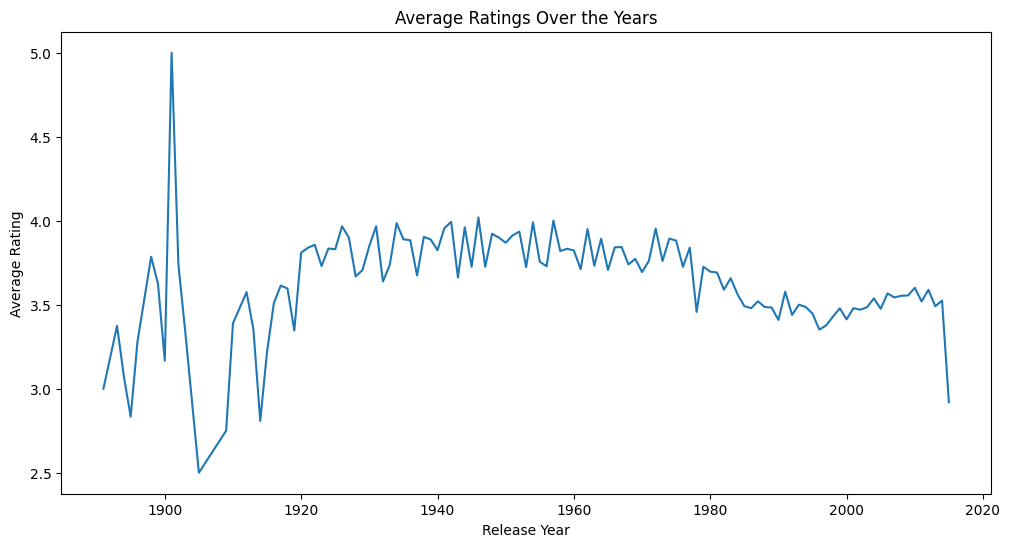

In [59]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='rating', data=eda_data.groupby('release_year')['rating'].mean().reset_index())
plt.title('Average Ratings Over the Years')
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_26328\3253941469.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='month', y='rating', data=eda_data, ci=None, palette='coolwarm')


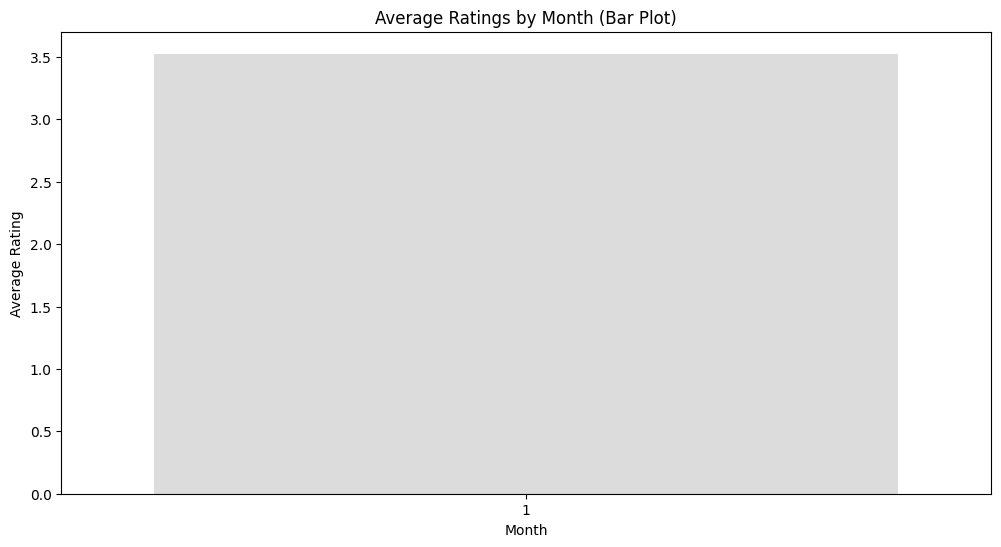

In [60]:
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='rating', data=eda_data, ci=None, palette='coolwarm')
plt.title('Average Ratings by Month (Bar Plot)')
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()

In [61]:
num_rating_df = data.groupby('title').count()['rating'].reset_index()
num_rating_df.rename(columns={'rating':'num_ratings'},inplace=True)
num_rating_df

,title,num_ratings
0,"""Great Performances"" Cats (1998)",155
1,#chicagoGirl: The Social Network Takes on a Di...,3
2,$ (Dollars) (1971),24
3,$5 a Day (2008),39
4,$9.99 (2008),55
...,...,...
26724,À propos de Nice (1930),4
26725,Árido Movie (2005),1
26726,Åsa-Nisse - Wälkom to Knohult (2011),2
26727,Üvegtigris (2001),1


In [62]:
avg_rating_df = data.groupby('title')['rating'].mean().reset_index()
avg_rating_df.rename(columns={'rating':'avg_ratings'}, inplace=True)
avg_rating_df

,title,avg_ratings
0,"""Great Performances"" Cats (1998)",2.748387
1,#chicagoGirl: The Social Network Takes on a Di...,3.666667
2,$ (Dollars) (1971),2.833333
3,$5 a Day (2008),2.871795
4,$9.99 (2008),3.009091
...,...,...
26724,À propos de Nice (1930),3.125000
26725,Árido Movie (2005),2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),1.500000
26727,Üvegtigris (2001),3.000000


In [63]:
avg_rating_df = data.groupby('title')['rating'].mean().reset_index()
avg_rating_df.rename(columns={'rating':'avg_ratings'}, inplace=True)
avg_rating_df

,title,avg_ratings
0,"""Great Performances"" Cats (1998)",2.748387
1,#chicagoGirl: The Social Network Takes on a Di...,3.666667
2,$ (Dollars) (1971),2.833333
3,$5 a Day (2008),2.871795
4,$9.99 (2008),3.009091
...,...,...
26724,À propos de Nice (1930),3.125000
26725,Árido Movie (2005),2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),1.500000
26727,Üvegtigris (2001),3.000000


In [64]:
popular_movies_df = num_rating_df.merge(avg_rating_df,on='title')
popular_movies_df

,title,num_ratings,avg_ratings
0,"""Great Performances"" Cats (1998)",155,2.748387
1,#chicagoGirl: The Social Network Takes on a Di...,3,3.666667
2,$ (Dollars) (1971),24,2.833333
3,$5 a Day (2008),39,2.871795
4,$9.99 (2008),55,3.009091
...,...,...,...
26724,À propos de Nice (1930),4,3.125000
26725,Árido Movie (2005),1,2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),2,1.500000
26727,Üvegtigris (2001),1,3.000000


In [65]:
popular_movies_df = popular_movies_df[popular_movies_df['num_ratings']>=300].sort_values('avg_ratings',ascending=False).head(50)
popular_movies_df.merge(movie_df,on='title').drop_duplicates('title').shape

popular_movies_df

,title,num_ratings,avg_ratings
20780,"Shawshank Redemption, The (1994)",63366,4.446990
9587,"Godfather, The (1972)",41355,4.364732
24968,"Usual Suspects, The (1995)",47006,4.334372
20318,Schindler's List (1993),50054,4.310175
9588,"Godfather: Part II, The (1974)",27398,4.275641
20601,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180
19204,Rear Window (1954),17449,4.271334
2073,Band of Brothers (2001),4305,4.263182
4237,Casablanca (1942),24349,4.258327
22421,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935


In [66]:
popular_movies_df.head(10)

,title,num_ratings,avg_ratings
20780,"Shawshank Redemption, The (1994)",63366,4.446990
9587,"Godfather, The (1972)",41355,4.364732
24968,"Usual Suspects, The (1995)",47006,4.334372
20318,Schindler's List (1993),50054,4.310175
9588,"Godfather: Part II, The (1974)",27398,4.275641
20601,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180
19204,Rear Window (1954),17449,4.271334
2073,Band of Brothers (2001),4305,4.263182
4237,Casablanca (1942),24349,4.258327
22421,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935


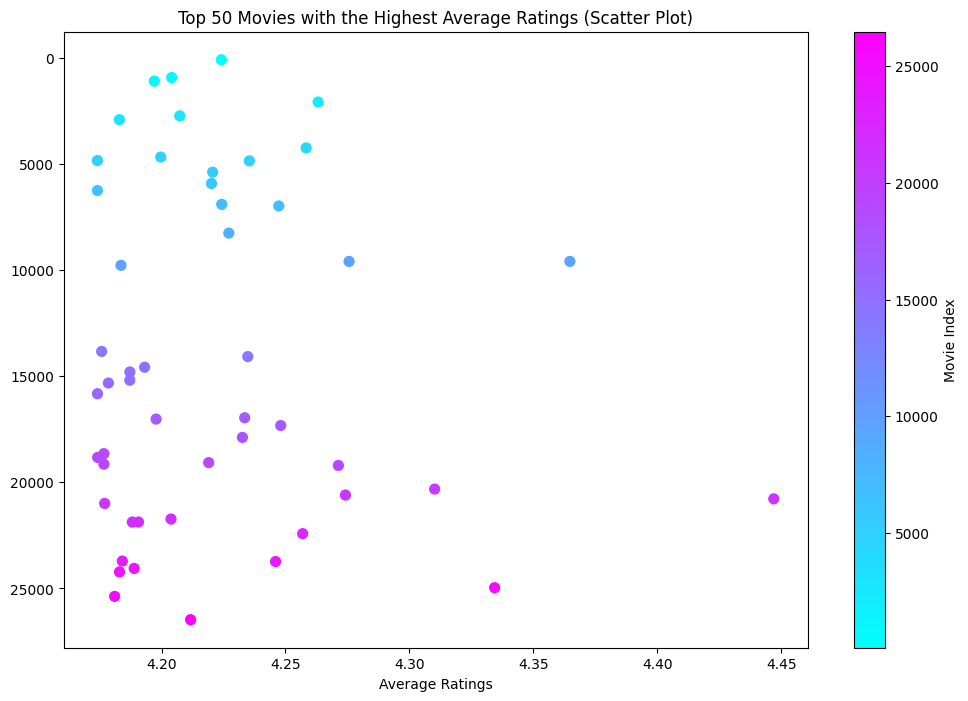

In [67]:
top_50_movies = popular_movies_df.head(50)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(top_50_movies['avg_ratings'], top_50_movies.index, c=top_50_movies.index, cmap='cool', s=50)
plt.xlabel('Average Ratings')
plt.title('Top 50 Movies with the Highest Average Ratings (Scatter Plot)')
plt.gca().invert_yaxis()
plt.colorbar(label='Movie Index', orientation='vertical')

plt.show()

In [68]:
#!pip install --upgrade keras tensorflow


**Matrix** **Factorization**

* We use the movies dataset and rating dataset, we then merge and check if all the data match. ​

* We then define a list of movies, It begins by filtering a DataFrame for certain movies, then produces a Surprise dataset and divides it into training and test sets. ​

* This data is used to train the SVD model, which is then assessed using RMSE. Finally, it predicts a rating for a given user-item pair, illustrating how the model may be employed to predict user preferences for movies.

In [69]:
movie = pd.read_csv('ml-20m/ml-20m/movies.csv')
rating = pd.read_csv('ml-20m/ml-20m/ratings.csv')
df = movie.merge(rating, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,9.449194e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,8.582755e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,8.339819e+08
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,9.434979e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,1.230859e+09


In [70]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 20000797
Columns: 6
------------------------------- TYPES --------------------------------
movieId        int64
title         object
genres        object
userId       float64
rating       float64
timestamp    float64
dtype: object
-------------------------------- HEAD --------------------------------
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating     timestamp  
0     3.0     4.0  9.449194e+08  
1     6.0     5.0  8.582755e+08  
2     8.0     4.0  8.339819e+08  
3    10.0     4.0  9.4

In [71]:
selected_movie_ids = [1, 131254, 4422, 131262]

selected_movies = ["Toy Story (1995)",
                   "Kein Bund für's Leben (2007)",
                   "Forrest Gump (1994)",
                   "Innocence (2014)"]
selected_movies_df = df[df.movieId.isin(selected_movie_ids)]

selected_movies_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,9.449194e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,8.582755e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,8.339819e+08
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,9.434979e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,1.230859e+09


In [72]:
selected_movies_df.shape

(50341, 6)

In [73]:
from surprise import Reader, SVD, Dataset, accuracy
rating_scale = (1, 5)

surprise_data = selected_movies_df[['userId', 'movieId', 'rating']]
surprise_reader = Reader(rating_scale=rating_scale)
surprise_data = Dataset.load_from_df(surprise_data, surprise_reader)

In [74]:

trainset, testset = train_test_split(surprise_data, test_size=.25)
svd_model = SVD()
svd_model.fit(trainset)

In [75]:
from surprise import accuracy

predictions = svd_model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

RMSE: 0.8915
Root Mean Squared Error (RMSE): 0.891507159720974


In [76]:
import numpy as np

def ndcg_at_k(y_true, y_score, k):

    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    # Compute Discounted Cumulative Gain (DCG)
    dcg = np.sum((2 ** y_true - 1) / np.log2(np.arange(2, y_true.size + 2)))

    # Compute Ideal DCG (IDCG)
    ideal_order = np.argsort(y_true)[::-1]
    ideal_dcg = np.sum((2 ** np.take(y_true, ideal_order) - 1) / np.log2(np.arange(2, y_true.size + 2)))

    # Compute Normalized DCG (nDCG)
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0

    return ndcg

In [77]:
# Calculate nDCG
nDCG_values = []

for user_id in set([user for (user, item, rating) in testset]):
    user_ratings = [(item, rating) for (user_t, item, rating) in testset if user_t == user_id]
    user_ratings.sort(key=lambda x: x[1], reverse=True)

    top_k_movies = [item for item, _ in user_ratings[:10]]
    top_k_predictions = [svd_model.predict(user_id, movie).est for movie in top_k_movies]
    top_k_actual_ratings = [rating for _, rating in user_ratings[:10]]

    nDCG = ndcg_at_k(top_k_actual_ratings, top_k_predictions, k=10)
    nDCG_values.append(nDCG)

mean_nDCG = np.mean(nDCG_values)
print("nDCG:", mean_nDCG)

nDCG: 0.9998570404174507


In [78]:
user_id = 1.0
item_id = 1
prediction = svd_model.predict(uid=user_id, iid=item_id, verbose=True)

print(f"User ID: {prediction.uid}")
print(f"Item ID: {prediction.iid}")
print(f"True Rating: {prediction.r_ui}")
print(f"Estimated Rating: {prediction.est}")
print(f"Details: {prediction.details}")


user: 1.0        item: 1          r_ui = None   est = 3.93   {'was_impossible': False}
User ID: 1.0
Item ID: 1
True Rating: None
Estimated Rating: 3.9274782537237476
Details: {'was_impossible': False}


In [79]:
user_id = 1.0
item_id = 4422
prediction = svd_model.predict(uid=user_id, iid=item_id, verbose=True)

print(f"User ID: {prediction.uid}")
print(f"Item ID: {prediction.iid}")
print(f"True Rating: {prediction.r_ui}")
print(f"Estimated Rating: {prediction.est}")
print(f"Details: {prediction.details}")


user: 1.0        item: 4422       r_ui = None   est = 3.92   {'was_impossible': False}
User ID: 1.0
Item ID: 4422
True Rating: None
Estimated Rating: 3.916215544472484
Details: {'was_impossible': False}


In [80]:

user_1_ratings = selected_movies_df[selected_movies_df["userId"] == 1]
print(user_1_ratings)

Empty DataFrame
Columns: [movieId, title, genres, userId, rating, timestamp]
Index: []


In [81]:
param_grid = {'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005, 0.007]}


gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

gs.fit(surprise_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    4.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.8s finished


In [82]:
gs.best_score['rmse']

0.8922630590689247

In [83]:
gs.best_params['rmse']

{'n_epochs': 20, 'lr_all': 0.002}

In [84]:
svd_model.n_epochs

20

In [85]:
svd_model = SVD(**gs.best_params['rmse'])

surprise_data = surprise_data.build_full_trainset()
svd_model.fit(surprise_data)



In [86]:
svd_model.predict(uid=1.0, iid=1, verbose=True)

user: 1.0        item: 1          r_ui = None   est = 3.92   {'was_impossible': False}


Prediction(uid=1.0, iid=1, r_ui=None, est=3.9209537866712143, details={'was_impossible': False})

In [87]:
svd_model.predict(uid=1.0, iid=130219, verbose=True)

user: 1.0        item: 130219     r_ui = None   est = 3.92   {'was_impossible': False}


Prediction(uid=1.0, iid=130219, r_ui=None, est=3.921852962793747, details={'was_impossible': False})

# **Item Based Collaborative Filtering**



**Our Approach**



* Our first step is to merge the movies dataset and the ratings dataset and to check the merged dataset to make sure that there a no errors or mismatch in the merge function. ​

* We then count the number of times a movie's title occurs. We also try and understand what are some rare movies that users might have not seen. ​

* Then we choose movies that are not on the list of rare movies, essentially filtering out rare movies.​

* Then we establish a boolean mask in which movies in rare_movies are tagged as False while others are marked as True.​

* The data is then restructured using a pivot table, which has userId as rows, movie names ("title") as columns, and their related ratings as cell values.​

* This is a common user-item interaction matrix structure used in collaborative filtering.​

* We the correlation between the selected film (The Matrix) and all other films in the restructured dataset. It use the corrwith function to compute pairwise correlation between two DataFrame objects' rows or columns.

* The results are sorted in descending order (ascending=False), with the top ten showing. The final result displays the top ten movies based on user ratings that are most comparable to "The Matrix," with "The Matrix" having a perfect correlation of 1.000000.​

### Pearson Correlation

In [104]:
movie_1 = pd.read_csv('ml-20m/ml-20m/movies.csv').reset_index()
rating_1 = pd.read_csv('ml-20m/ml-20m/ratings.csv').reset_index()

In [105]:
df_merged = movie_1.merge(rating_1, how="left", on="movieId")

In [106]:
def check_df(dataframe, head=5):
    print('Shape')
    print(dataframe.shape)
    print('Types')
    print(dataframe.dtypes)
    print('Head')
    print(dataframe.head(head))
    print('Tail')
    print(dataframe.tail(head))
    print('Null Values')
    print(dataframe.isnull().sum())
    print('Quantiles')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df_merged)

Shape
(20000797, 8)
Types
index_x        int64
movieId        int64
title         object
genres        object
index_y      float64
userId       float64
rating       float64
timestamp    float64
dtype: object
Head
   index_x  movieId             title  \
0        0        1  Toy Story (1995)   
1        0        1  Toy Story (1995)   
2        0        1  Toy Story (1995)   
3        0        1  Toy Story (1995)   
4        0        1  Toy Story (1995)   

                                        genres  index_y  userId  rating  \
0  Adventure|Animation|Children|Comedy|Fantasy    236.0     3.0     4.0   
1  Adventure|Animation|Children|Comedy|Fantasy    517.0     6.0     5.0   
2  Adventure|Animation|Children|Comedy|Fantasy    817.0     8.0     4.0   
3  Adventure|Animation|Children|Comedy|Fantasy    922.0    10.0     4.0   
4  Adventure|Animation|Children|Comedy|Fantasy    960.0    11.0     4.5   

      timestamp  
0  9.449194e+08  
1  8.582755e+08  
2  8.339819e+08  
3  9.434979e+08  

In [109]:
movie_df_counts = pd.DataFrame(df_merged["title"].value_counts()).reset_index()
movie_df_counts.head(20)

,title,count
0,Pulp Fiction (1994),67310
1,Forrest Gump (1994),66172
2,"Shawshank Redemption, The (1994)",63366
3,"Silence of the Lambs, The (1991)",63299
4,Jurassic Park (1993),59715
5,Star Wars: Episode IV - A New Hope (1977),54502
6,Braveheart (1995),53769
7,Terminator 2: Judgment Day (1991),52244
8,"Matrix, The (1999)",51334
9,Schindler's List (1993),50054


In [111]:
rare_movies = movie_df_counts[movie_df_counts["count"] <= 1000].index
rare_movies
rare_movie_titles = rare_movies['title']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
common_movies = df_merged[~df_merged["title"].isin(rare_movies)]

In [ ]:
common_movies["title"].nunique()

0

In [ ]:
df_merged["title"].nunique()

9737

In [ ]:
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")

In [ ]:
user_movie_df.shape

(0, 0)

In [ ]:
user_movie_df.columns

Index([], dtype='object', name='title')

In [ ]:
movie_name1 = "Mission: Impossible (1996)"

In [ ]:
movie_name = user_movie_df[movie_name1]

KeyError: 'Mission: Impossible (1996)'

In [ ]:
user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(10)

title
Mission: Impossible (1996)                     1.000000
Mission: Impossible III (2006)                 0.546713
Mission: Impossible II (2000)                  0.505765
Mission: Impossible - Ghost Protocol (2011)    0.476099
Cocktail (1988)                                0.441352
GoldenEye (1995)                               0.426756
Tomorrow Never Dies (1997)                     0.418250
Top Gun (1986)                                 0.408289
World Is Not Enough, The (1999)                0.405434
Ocean's Eleven (2001)                          0.400077
dtype: float64

In [ ]:
movie_name2 = "Batman & Robin (1997)"

In [ ]:
movie_name = user_movie_df[movie_name2]

KeyError: 'Batman & Robin (1997)'

In [ ]:
user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(10)

title
Batman & Robin (1997)                      1.000000
Batman Forever (1995)                      0.620899
Catwoman (2004)                            0.620201
First Kid (1996)                           0.572027
Man of the House (1995)                    0.541543
Speed 2: Cruise Control (1997)             0.538331
Superman IV: The Quest for Peace (1987)    0.517121
D3: The Mighty Ducks (1996)                0.515045
Jack Frost (1998)                          0.513860
Universal Soldier: The Return (1999)       0.513829
dtype: float64

Evaluation metrics for Cosine similarity and pearson correlation using KNN

In [112]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
import numpy as np

# Load data
movies = pd.read_csv('ml-20m/ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ml-20m/ratings.csv')
df = pd.merge(ratings, movies, on='movieId')

# Create Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Train item-based collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Generate predictions
predictions = model.test(testset)

# Calculate RMSE
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Calculate nDCG
def ndcg_at_k(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    dcg = np.sum((2 ** y_true - 1) / np.log2(np.arange(2, y_true.size + 2)))
    ideal_order = np.argsort(y_true)[::-1]
    ideal_dcg = np.sum((2 ** np.take(y_true, ideal_order) - 1) / np.log2(np.arange(2, y_true.size + 2)))
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg

nDCG_values = []
for user_id in df['userId'].unique():
    user_ratings = df[df['userId'] == user_id]
    user_movie_ratings = [(row['movieId'], row['rating']) for index, row in user_ratings.iterrows()]
    user_movie_ratings.sort(key=lambda x: x[1], reverse=True)

    top_k_movies = [movie for movie, _ in user_movie_ratings[:10]]
    top_k_predictions = [model.predict(user_id, movie).est for movie in top_k_movies]
    top_k_actual_ratings = [rating for _, rating in user_movie_ratings[:10]]

    nDCG = ndcg_at_k(top_k_actual_ratings, top_k_predictions, k=10)
    nDCG_values.append(nDCG)

mean_nDCG = np.mean(nDCG_values)
print("nDCG:", mean_nDCG)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9288
RMSE: 0.9288392389198071
nDCG: 0.9820627394940449


In [113]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
import numpy as np

# Load data
movies = pd.read_csv('ml-20m/ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ml-20m/ratings.csv')
df = pd.merge(ratings, movies, on='movieId')

# Create Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Train item-based collaborative filtering model
sim_options = {'name': 'pearson', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Generate predictions
predictions = model.test(testset)

# Calculate RMSE
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Calculate nDCG
def ndcg_at_k(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    dcg = np.sum((2 ** y_true - 1) / np.log2(np.arange(2, y_true.size + 2)))
    ideal_order = np.argsort(y_true)[::-1]
    ideal_dcg = np.sum((2 ** np.take(y_true, ideal_order) - 1) / np.log2(np.arange(2, y_true.size + 2)))
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg

nDCG_values = []
for user_id in df['userId'].unique():
    user_ratings = df[df['userId'] == user_id]
    user_movie_ratings = [(row['movieId'], row['rating']) for index, row in user_ratings.iterrows()]
    user_movie_ratings.sort(key=lambda x: x[1], reverse=True)

    top_k_movies = [movie for movie, _ in user_movie_ratings[:10]]
    top_k_predictions = [model.predict(user_id, movie).est for movie in top_k_movies]
    top_k_actual_ratings = [rating for _, rating in user_movie_ratings[:10]]

    nDCG = ndcg_at_k(top_k_actual_ratings, top_k_predictions, k=10)
    nDCG_values.append(nDCG)

mean_nDCG = np.mean(nDCG_values)
print("nDCG:", mean_nDCG)

Computing the pearson similarity matrix...


MemoryError: Unable to allocate 4.88 GiB for an array with shape (25588, 25588) and data type float64

## **Deep Learning based Recommendation System**




**Explanation**

* Implicit feedback - Indirect feedback is gathered via user interactions and serves as a substitute for user preference. Videos you view on YouTube, for example, are utilized as implicit feedback to customize suggestions to you, even if you don't rate the videos directly.​

* Implicit feedback also allows us to tailor recommendations in real time, with every click and interaction​

* The Neural Network-based Collaborative Filtering (CF) model employs a deep learning method for recommendation systems. ​

* Using implicit feedback, we will train a recommender system. We siimply binarize the ratings such that they are '1' (i.e. positive class) to transform this dataset into an implicit feedback dataset. The number '1' indicates that the user watched the movie.​

* This approach represents users and items as embeddings, which are low-dimensional vectors that capture their attributes. ​

* The embeddings of the user and items are fed into a neural network, which learns to predict ratings based on these embeddings. ​

* When compared to standard matrix factorization algorithms, our method captures complicated and non-linear interactions between users and things, resulting in more accurate suggestions.​





In [114]:
np.random.seed(123)

In [115]:
ratings_2 = pd.read_csv('ml-20m/ml-20m/ratings.csv', parse_dates=['timestamp'])

C:\Users\harsh\AppData\Local\Temp\ipykernel_26328\1556436979.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ratings_2 = pd.read_csv('ml-20m/ml-20m/ratings.csv', parse_dates=['timestamp'])


In [116]:
rand_user = np.random.choice(ratings_2['userId'].unique(),size=int(len(ratings_2['userId'].unique())*0.3),replace=False)

ratings_2 = ratings_2.loc[ratings_2['userId'].isin(rand_user)]

print('There are {} rows of data from {} users'.format(len(ratings_2), len(rand_user)))

There are 6027314 rows of data from 41547 users


In [117]:
ratings_2.sample(10)

,userId,movieId,rating,timestamp
3840312,26182,3704,4.0,1170280612
7608731,52439,3365,4.0,1079856176
19363634,134060,1027,3.0,1058309025
17181947,118860,2629,1.0,1196371628
9344779,64638,4723,2.0,1000152701
10356404,71637,3882,0.5,1077241733
962965,6460,11,4.0,845988812
12014375,82949,54001,4.5,1281112765
10532053,72855,7158,2.5,1311556078
18710288,129551,1228,4.5,1182989862


In [118]:
ratings_2['rank_latest'] = ratings_2.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings_2[ratings_2['rank_latest'] != 1]
test_ratings = ratings_2[ratings_2['rank_latest'] == 1]


train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [119]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(10)

,userId,movieId,rating
3411906,23263,5481,1.0
1815983,12245,5464,1.0
16198592,112109,6,1.0
13914487,96124,1247,1.0
1445807,9790,1690,1.0
11467559,79181,1757,1.0
1764803,11940,5673,1.0
18402598,127366,64839,1.0
1029887,6976,69746,1.0
4867506,33444,1960,1.0


Below Code:

* It gathers all unique movie IDs before iterating over user-movie combinations and marking each as a "positive" interaction.

* It creates four 'negative' samples (movies not interacted with by the user) for each positive case.

* The technique generates a balanced dataset including both positive and negative instances, which is critical for training useful recommendation system

In [120]:

all_movieIds = ratings_2['movieId'].unique()

users, items, labels = [], [], []

user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1)
    for _ in range(num_negatives):
        negative_item = np.random.choice(all_movieIds)
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0)

100%|██████████| 5985767/5985767 [03:40<00:00, 27141.73it/s]


 * It starts with user ratings and movie IDs and builds a dataset of user-movie interactions that are categorized as positive (the user interacted with the movie) or negative (the user did not interact).

 * It produces four negative interactions at random for each good interaction, guaranteeing that these negative instances are not present in the user's interacted movies.
 This method is commonly used in the development of machine learning-based recommendation systems.

In [121]:
class MovieLensTrainDataset(Dataset):

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

* Using PyTorch Lightning, this code creates a Neural Collaborative Filtering (NCF) model.

* It has user and item embedding layers, fully linked layers, and a sigmoid output layer for binary classification.

* The data flows over the network is defined by the 'forward' mechanism. It entails embedding users and items, concatenating these embeddings, passing them through dense layers activated by ReLU, and ultimately a sigmoid activation for prediction.

* For training, the 'training_step' technique computes the binary cross-entropy loss. For training data, the model use the Adam optimizer and a custom DataLoader.

In [122]:
class NCF(pl.LightningModule):

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=32, num_workers=2)

In [123]:
num_users = ratings_2['userId'].max()+1
num_items = ratings_2['movieId'].max()+1

all_movieIds = ratings_2['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [132]:
trainer = pl.Trainer(max_epochs=3, accelerator="cpu")
trainer.fit(model, datamodule=data_module)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.1 M 
1 | item_embedding | Embedding | 1.1 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.645     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 37140) exited unexpectedly

* This code uses a Hit Ratio statistic to assess a recommendation model. It determines if the actual item (movie) with which a user interacts is among the top ten suggested movies.

* It produces 99 movies not interacted with by the user for each user-item combination in the test set, mixes them with the actual interacted item, and predicts the probability of the user interacting with these 100 movies. If the real item is in the top ten of these predictions, it is termed a "hit."

* The Hit Ratio @ 10 is the average of these hits, and it indicates how well the model is in predicting user preferences.

In [ ]:

test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

user_interacted_items = ratings_2.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 183/183 [00:00<00:00, 496.59it/s]

The Hit Ratio @ 10 is 0.26


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have test data with actual ratings and predicted ratings
actual_ratings = test_ratings['rating'].values  # Actual ratings
predicted_ratings = model(torch.tensor(test_ratings['userId'].values),
                          torch.tensor(test_ratings['movieId'].values)).detach().numpy().flatten()  # Predicted ratings

rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("RMSE:", rmse)


RMSE: 3.6415352510676846


In [ ]:
def dcg_at_k(ranked_list, k):
    dcg = 0
    for i in range(min(k, len(ranked_list))):
        dcg += (2 ** ranked_list[i] - 1) / np.log2(i + 2)
    return dcg

def ndcg_at_k(actual, predicted, k):
    sorted_indices = np.argsort(-predicted)
    actual_sorted = actual[sorted_indices]
    dcg = dcg_at_k(actual_sorted, k)
    idcg = dcg_at_k(np.sort(actual)[::-1], k)
    if idcg == 0:
        return 0
    return dcg / idcg


actual_ratings_per_user = []
predicted_ratings_per_user = []
for user_id in test_ratings['userId'].unique():
    user_ratings = test_ratings[test_ratings['userId'] == user_id]['rating'].values
    user_predicted_ratings = predicted_ratings[test_ratings['userId'] == user_id]
    actual_ratings_per_user.append(user_ratings)
    predicted_ratings_per_user.append(user_predicted_ratings)

# Calculate nDCG@10 for each user and average across all users
nDCG_values = [ndcg_at_k(actual, predicted, 10) for actual, predicted in zip(actual_ratings_per_user, predicted_ratings_per_user)]
nDCG = np.mean(nDCG_values)
print("nDCG@10:", nDCG)


nDCG@10: 1.0


### Cold Start problem

The cold start problem arises in recommendation systems when there is insufficient data about new users or items, making it challenging to provide accurate recommendations solely based on user-item interactions. One approach to address this issue is through content-based filtering.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter


movies = pd.read_csv("ml-20m/ml-20m/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
# Splitting genres and creating a list
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))

In [ ]:
# Counting occurrences of each genre
genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")

There are 20 genre labels.


In [ ]:
# Removing movies with no genre listed
movies = movies[movies['genres'] != '(no genres listed)']
del genres_counts['(no genres listed)']

In [ ]:
# Printing the 5 most common genres
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


In [ ]:
# Converting Counter to DataFrame for plotting
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)


<ipython-input-8-2d6203877f60>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')


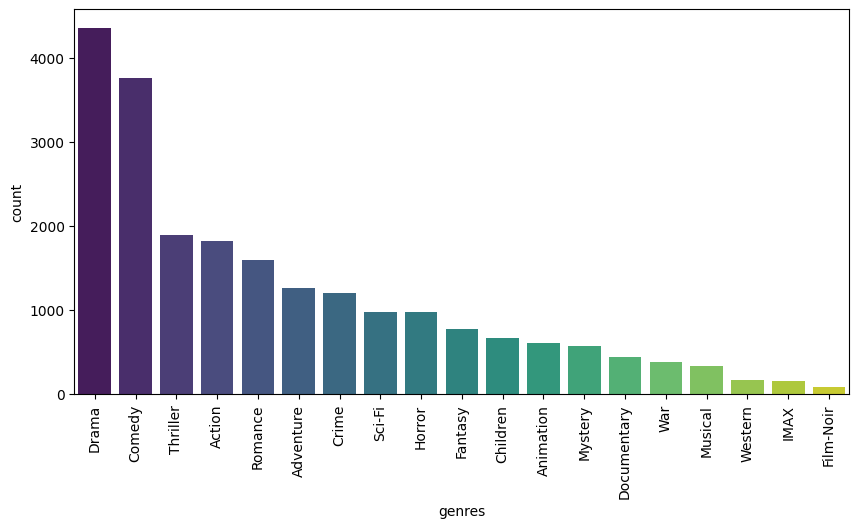

In [ ]:
# Plotting genre counts
plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Function to extract year from movie title
def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

In [ ]:
# Applying the function to create a 'year' column
movies['year'] = movies['title'].apply(extract_year_from_title)

# Removing rows with null years
movies = movies.dropna(subset=['year'])
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
5,6,Heat (1995),"[Action, Crime, Thriller]",1995
6,7,Sabrina (1995),"[Comedy, Romance]",1995
7,8,Tom and Huck (1995),"[Adventure, Children]",1995
8,9,Sudden Death (1995),[Action],1995
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]",1995


In [ ]:
# Counting unique years
print(f"Number of unique years: {movies['year'].nunique()}")


Number of unique years: 106


In [ ]:
# Removing null years
print(f"Original number of movies: {movies['movieId'].nunique()}")
movies = movies.dropna(subset=['year'])
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")


Original number of movies: 9718
Number of movies after removing null years: 9718


In [ ]:
# Function to get decade from year
def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

# Applying the function to create a 'decade' column
movies['decade'] = movies['year'].apply(get_decade)

Transforming the Data:
In order to build a content-based filtering recommender, we need to set up our dataset so that rows represent movies and columns represent features (i.e., genres and decades).

First, we need to manipulate the genres column so that each genre is represented as a separate binary feature. "1" indicates that the movie falls under a given genre, while "0" does not.

In [ ]:
!pip install fuzzywuzzy


In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Define genres
genres = list(genres_counts.keys())

# Create genre binary features
for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

In [ ]:
# One-hot encode movie decades
movie_decades = pd.get_dummies(movies['decade'])

# Concatenate genre binary features and decade one-hot encoded features
movie_features = pd.concat([movies[genres], movie_decades], axis=1)


In [ ]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(movie_features, movie_features)

# Function to find the closest matching movie title
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

# Function to get content-based recommendations
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])


In [ ]:
# Finding movie index from title
movie_idx = dict(zip(movies['title'], list(movies.index)))

# Example usage
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object


# References

* https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

* https://www.mygreatlearning.com/blog/matrix-factorization-explained/

* https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab

* https://medium.com/data-science-in-your-pocket/recommendation-systems-using-neural-collaborative-filtering-ncf-explained-with-codes-21a97e48a2f7

* https://towardsdatascience.com/fast-ai-season-1-episode-5-1-movie-recommendation-using-fastai-a53ed8e41269

